# Incantations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import time
sns.set()
%matplotlib inline

/Users/student/miniconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Representation of biological agents

## creating the IFT environment
I use the class Cell to create the environment on which IFT particles can move. A cell has attributes including length, transport speed, avalanching capability, and binding probabilities. Cells also have the functions sim() and time_step() that advance time.

In [336]:
class Cell:
    cells = []
    
    def __init__(self, L, N, trans_speed=5, k_on=.2, k_off=.2, 
                 avalanche_on=False, thresh=10, num_release = 5,
                L_mod=False, build_size=10, decay_size=.1): #L is length, N is number of particles
        self.L = L
        self.trans_speed = trans_speed
        self.k_on = k_on
        self.k_off = k_off
        self.N = N
        self.motors = [Motor(self) for i in range(N)]
        self.track_active = [0]
        self.active50 = self.N
        self.avalanche_on = avalanche_on
        self.thresh = thresh
        self.num_release = num_release
        self.recruited = 0
        self.L_mod = L_mod
        self.build_size=build_size
        self.decay_size=decay_size
        self.L_trace=[self.L]
        
    def count_active(self):
        return sum([p.isactive for p in self.motors])
    
    def sim(self, tot_time, terminate50 = True):
        
        for i in range(tot_time):
            self.time_step()
            self.track_active.append(self.count_active())
            
#             if self.active50 == self.N and self.count_active() <= self.N/2:
#                 self.active50 = i
#                 if terminate50:
#                     return
    
    def time_step(self):
#         print(self.count_active())
        if self.avalanche_on:
            self.avalanche()
        
        if self.L_mod:
            if self.L >= self.decay_size:
                self.L -= self.decay_size

            self.L_trace.append(self.L)
        
        for p in self.motors:
            
            
            if p.isactive:
                if p.isbound:
                    p.active_trans()
                else:
                    p.diffuse()
#             else:
#                 self.inactive += 1
            p.track.append(p.pos)

    def avalanche(self):
        num_inactive = self.N - self.count_active()
        inactive = [p for p in self.motors if not p.isactive]
        if num_inactive > self.thresh:
            for i in range(self.num_release):
                inactive[i].isactive = True
                inactive[i].isbound = True
                
                if self.L_mod:
                    inactive[i].built = False
            self.recruited += self.num_release

    
    def __repr__(self):
        string = 'Cell of length %s populated by %d motors' %(self.L,self.N)                                                          
        return string

## representing kinesins as a class

The class Motor represents a kinesin that populates the cell. Motors have the ability to diffuse or active transport.

In [441]:
class Motor:
    
    instances = []
    
    def __init__(self, cell, isactive = True, isbound=True):
        self.pos = 0
        self.isactive = isactive
        self.isbound = isbound
        self.track = [0]
        Motor.instances.append(self)
        self.cell=cell
        self.built = False
    
    def diffuse(self):
        if self.isactive:
            
            if not self.cell.L_mod:
#                 if self.isactive:
                if self.pos == self.cell.L:
                    self.binding()
    #                 print(self.isbound)

    #                 if not self.binding(): #check if it re-binds, don't move if it does
    # #                 print(self.isbound)
                    if self.isbound == False:
                        self.pos -= 1


                elif self.pos == 0:
                    self.isactive = False #keep this for later, using avalanche model

    #                 self.isbound = True

                else:
                    self.pos += random.choice([-1,1])
#             self.track.append(self.pos)

        
            elif self.cell.L_mod:
                if self.pos > self.cell.L: #for length decay
                    self.pos = self.cell.L

                if self.pos == self.cell.L:
                    self.binding()



                    if self.isbound:
                        if not self.built:
                            self.cell.L += self.cell.build_size
                            self.built = True


                    if self.built or not self.isbound:
                        self.pos -= 1

                            
                else:
                    self.pos += random.choice([-1,1])
    #             self.track.append(self.pos)

                if self.pos <= 0:
                    self.isactive = False #keep this for later, using avalanche model


    #                     elif self.isbound == False:
    #                         self.pos += random.choice([-1,1])
    #                         elif not self.isbound:
    #                             self.pos -= 1

    #                  if self.isbound == False:
    # #                     self.pos -= 1
    #                             self.pos += random.choice([-1,1])

    #                 print(self.isbound)


    #                 if not self.binding(): #check if it re-binds, don't move if it does
    # #                 print(self.isbound)


    #             if self.pos == 0:
    #                 self.isactive = False #keep this for later, using avalanche model

    #                 self.isbound = True

    def active_trans(self):
        if self.pos < self.cell.L:
            self.pos += self.cell.trans_speed
            self.pos = min(self.pos,self.cell.L)
        if self.pos == self.cell.L:
            self.isbound = False
#         self.track.append(self.pos)

    def binding(self):
        roll = np.random.rand()
        if self.isbound == False:
            if roll < self.cell.k_on: #probability of binding to the IFT particle, stalling diffusion
                self.isbound = True
#                 print('bound!')
        else: #if self.isbound == True
            if roll < self.cell.k_off:
                self.isbound = False
#                 print('unbound!')
                
        return self.isbound #return the updated bound state
    
    def trace(self):
        plt.plot(self.track);
        plt.xlabel('time')
        plt.ylabel('position')
        
    def __repr__(self):
        string = 'Motor at position %s' %self.pos
        return(string)

### Example of cell creation and time simulation

In [219]:
new_cell=Cell(L=10,N=15)

In [220]:
new_cell.sim(100)

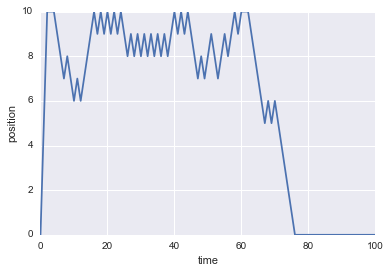

In [222]:
new_cell.motors[0].trace()
plt.ylim(0);

# Diffusion back to base

In [36]:
size_avgs=[]
# sizes = [10,100,1000,10000]
sizes = [10, 25, 50, 75, 100]
num_sims = 100
num_p = 300
T = 10000
timer=time.time()

for length in sizes:
    for i in range(num_sims):

        t_list = np.zeros(num_sims)
        c = Cell(L=length,N=num_p)
        c.sim(T)
        t_list[i]=(c.active50)
    size_avgs.append(np.mean(t_list))
    print(time.time()-timer)

37.44108009338379
66.11816501617432
177.14642119407654
424.6545271873474
851.6623029708862


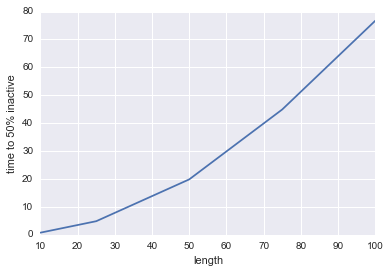

In [37]:
plt.plot(sizes,size_avgs);
plt.xlabel('length');
plt.ylabel('time to 50% inactive');

In [41]:
fit = np.polyfit(sizes,size_avgs,2)
fitx = np.linspace(0,100,100)

fity = [fit[0]*(x**2)+fit[1]*x for x in fitx]

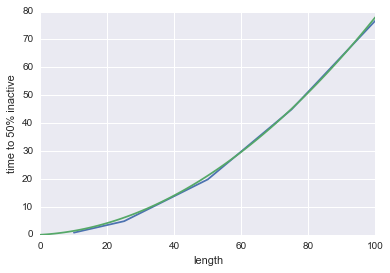

In [42]:
plt.plot(sizes,size_avgs);
plt.plot(fitx,fity)
plt.xlabel('length');
plt.ylabel('time to 50% inactive');


In [48]:
fitstr = '%sx^2 + %sx + %s' %(round(fit[0],3),round(fit[1],3), round(fit[2],3))
print(fitstr)

0.007x^2 + 0.069x + -0.955


In [54]:
np.mean([p.pos for p in c.particles])

31.813333333333333

don't touch above

# Avalanching behavior

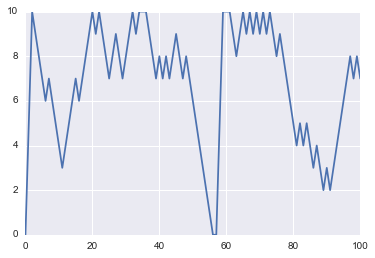

In [71]:
ava_cell.motors[4].trace()

In [69]:
ava_cell = Cell(L=10,N=100,avalanche_on=True)
sim_steps = 100

In [70]:
ava_cell.sim(sim_steps)

In [74]:
recruit_rate = ava_cell.recruited/sim_steps
recruit_rate

0.7

In [141]:
sim_steps = 10000
recruit_rates = []
lengths = [5,10,11,12,15,17,20,25,30,40]
for length in lengths:
    cell=Cell(L=length, N=1000, avalanche_on=True)
    cell.sim(sim_steps)
    recruit_rates.append(cell.recruited/sim_steps)

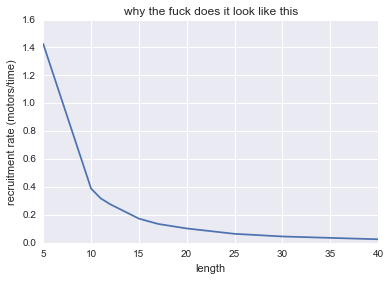

In [154]:
plt.plot(lengths,recruit_rates);
plt.xlabel('length');
plt.ylabel('recruitment rate (motors/time)');
plt.title('why the fuck does it look like this');

In [147]:
short = Cell(L=5,N=100, avalanche_on=True)
short.sim(100)

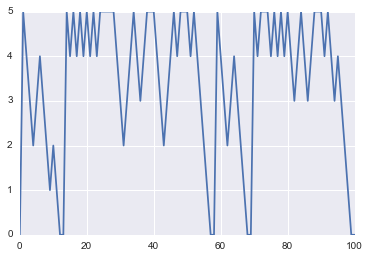

In [149]:
short.motors[1].trace()

goals: we know that when length increases, more motors are recruited. Can we understand this? Try implementing the avalanche model, modify length and see how recruitment changes.

Also change 'particle' to motor

When the number of motors is comparable to the avalanche paramaters, the recruitment rate decreases in what looks like a power law or exponential decay.

In [151]:
sim_steps = 10000
recruit_rates = []
lengths = [5,10,11,12,15,17,20,25,30,40]
for length in lengths:
    cell=Cell(L=length, N=50, avalanche_on=True)
    cell.sim(sim_steps)
    recruit_rates.append(cell.recruited/sim_steps)

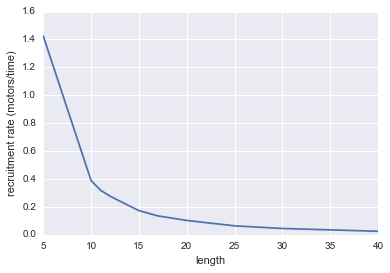

In [155]:
plt.plot(lengths,recruit_rates);
plt.xlabel('length');
plt.ylabel('recruitment rate (motors/time)');

When the number of motors is much higher than the avalanche parameters, we have the same decay for high lengths, but we see a local maximum at fairly low lengths. See plot below.

In [193]:
sim_steps = 10000
recruit_rates_highN = []
lengths = [5,10,11,12,15,17,20,25,30,40]
for length in lengths:
    cell=Cell(L=length, N=1000, avalanche_on=True)
    cell.sim(sim_steps)
    recruit_rates_highN.append(cell.recruited/sim_steps)

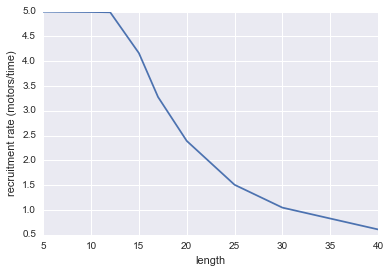

In [194]:
plt.plot(lengths,recruit_rates_highN);
plt.xlabel('length');
plt.ylabel('recruitment rate (motors/time)');

In [176]:
sim_steps = 10000
cell_5=Cell(L=5, N=50, avalanche_on=True)
cell_5.sim(sim_steps)
rate_5 = cell_5.recruited/sim_steps

In [177]:
rate_5

1.425

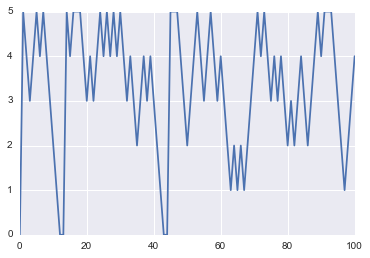

In [164]:
cell_5.motors[0].trace()

In [174]:
sim_steps = 10000
cell_11=Cell(L=11, N=50, avalanche_on=True)
cell_11.sim(sim_steps)
rate_11 = cell_11.recruited/sim_steps

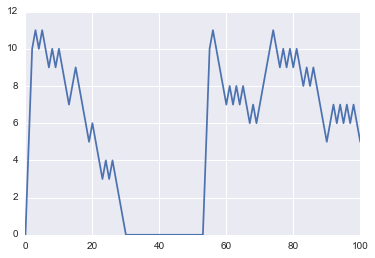

In [172]:
cell_11.motors[5].trace()

In [175]:
rate_11

0.3265

In [182]:
sim_steps = 10000
cell_11_highN=Cell(L=11, N=1000, avalanche_on=True)
cell_11_highN.sim(sim_steps)
rate_11_highN = cell_11_highN.recruited/sim_steps

In [183]:
rate_11_highN

4.9885

In [190]:
sim_steps = 10000
cell_5_highN=Cell(L=5, N=1000, avalanche_on=True)
cell_5_highN.sim(sim_steps)
rate_5_highN = cell_5_highN.recruited/sim_steps

In [191]:
rate_5_highN

4.9965

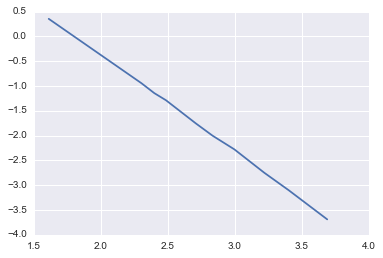

In [201]:
plt.plot(np.log(lengths),np.log(recruit_rates))

Below I calculate the fit of this curve and find that it is inverse square. Diffusion?

In [203]:
np.polyfit(np.log(lengths),np.log(recruit_rates),1) #power law -- inverse square!

array([-1.94644865,  3.52048873])

Notes from meeting 5 May 2015:

Try building into the model:
Every time motor gets to the tip, length increases. Length randomly decreases at each time step. See steady state length based on grow/shrink params.

L=10um

# Length alteration

Here I will implement the length-changing system, in which motors will increase the length when they get to the tip, and the length will spontaneously decrease at each time interval.

In [390]:
lmodcell=Cell(L=10,N=500,avalanche_on=True,L_mod=True)

In [391]:
lmodcell.sim(10000)

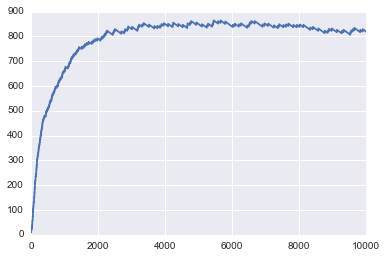

In [394]:
# lmodcell.motors[1].trace()
plt.plot(lmodcell.L_trace);

Notes 5 May 2016:
Graph above looks good, looks like steady state length! Check everything tomorrow, make sure what's going on is right. Maybe make a flowchart and track?

In [310]:
len(lmodcell.motors[0].track)

201

In [311]:
len(lmodcell.L_trace)

201

In [350]:
overlap=0
for i,a in enumerate(lmodcell.L_trace):
    if lmodcell.L_trace[i] < lmodcell.motors[0].track[i]:
        print(i)


3
3487
3490
3503
3506
3516
3543
3847
4057
4083
40887
40893
40909
40913
40919
40921
40933
40939
40955
40957
40961
41092
41100
41110
41237
41347
41361
41365
41918
41941
41946
42154
42156
42160
42230
42250
42264
42358
42399
42411
42414
42420
42496
42504
42508
42752
42766
43311
43332
43361
43389
43393
43395
43615
43621
43731
43735
44267
44269
44281
44441
44463
44475
44479
44487
44807
44811
44813
44890
44894
44898
44900
44902
44904
44906
44908
44934
44968
44998
45008
45010
45014
45016
45018
45058
45066
45106
45112
45297
46454
46523
46525
46585
46614
46620
46628
46634
46640
46642
46646
48412
48420
48422
48470
48474
62382
62384


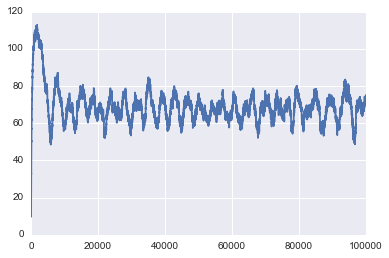

In [403]:
lmodcell=Cell(L=10,N=500,avalanche_on=True,L_mod=True, build_size=1)
lmodcell.sim(100000)
plt.plot(lmodcell.L_trace);

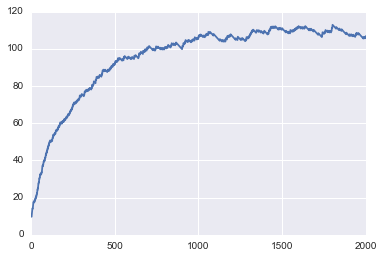

In [417]:
plt.plot(lmodcell.L_trace);
plt.xlim(0,2000); #before it goes down

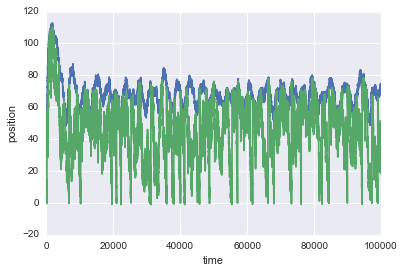

In [404]:
plt.plot(lmodcell.L_trace);
lmodcell.motors[0].trace()

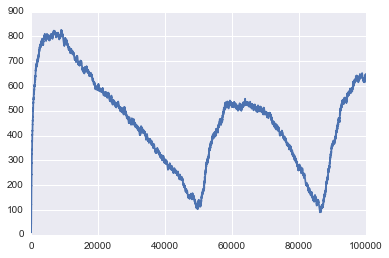

In [405]:
lmodcell_highBS=Cell(L=10,N=500,avalanche_on=True,L_mod=True, build_size=10)
lmodcell_highBS.sim(100000)
plt.plot(lmodcell_highBS.L_trace);

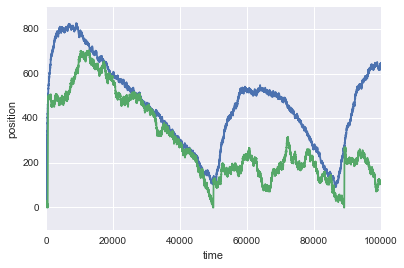

In [406]:
plt.plot(lmodcell_highBS.L_trace);
lmodcell_highBS.motors[0].trace()

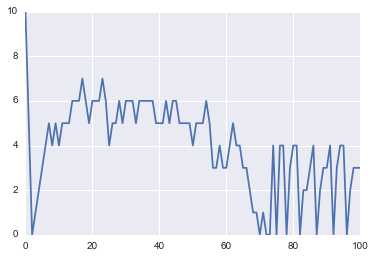

In [411]:
lmodcell_highdecay=Cell(L=10,N=500,avalanche_on=True,L_mod=True, build_size=1, decay_size=5)
lmodcell_highdecay.sim(100)
plt.plot(lmodcell_highdecay.L_trace);

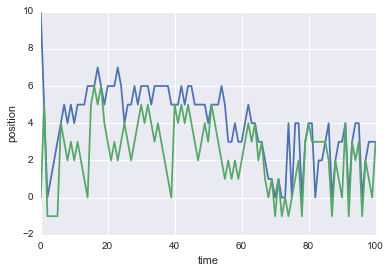

In [412]:
plt.plot(lmodcell_highdecay.L_trace);
lmodcell_highdecay.motors[0].trace()

In [445]:
sim_steps = 10000
recruit_ratesAAA = []
lengths = [5,10,15,20,30,40]
for length in lengths:
    cell=Cell(L=length, N=50, avalanche_on=True, L_mod=False)
    cell.sim(sim_steps)
    recruit_ratesAAA.append(cell.recruited/sim_steps)
    

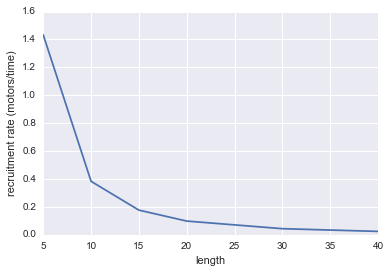

In [446]:
plt.plot(lengths,recruit_ratesAAA);
plt.xlabel('length');
plt.ylabel('recruitment rate (motors/time)');

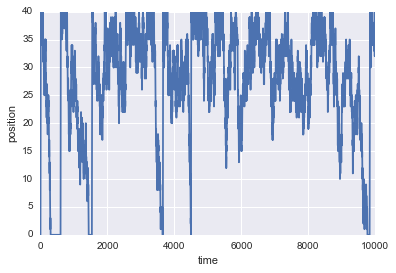

In [447]:
cell.motors[1].trace()

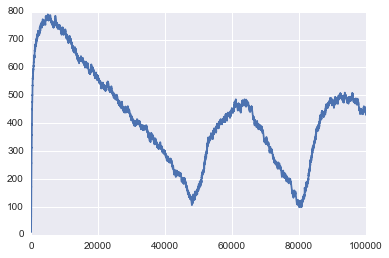

In [450]:
lmodcell_highBS=Cell(L=10,N=500,avalanche_on=True,L_mod=True, build_size=10)
lmodcell_highBS.sim(100000)
plt.plot(lmodcell_highBS.L_trace);

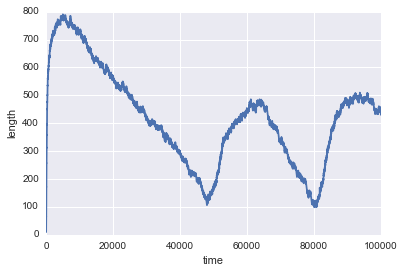

In [451]:
plt.plot(lmodcell_highBS.L_trace);
plt.xlabel('time');
plt.ylabel('length');

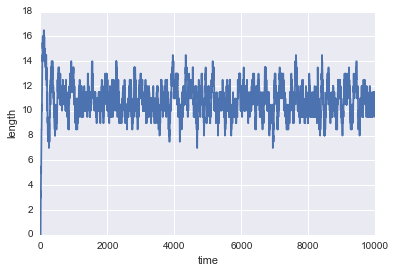

In [462]:
lmodcell_lowN=Cell(L=0,N=200,avalanche_on=True,L_mod=True, build_size=.5, decay_size=.5)
lmodcell_lowN.sim(10000)
plt.plot(lmodcell_lowN.L_trace);
plt.xlabel('time');
plt.ylabel('length');